<function matplotlib.pyplot.imshow(X: 'ArrayLike | PIL.Image.Image', cmap: 'str | Colormap | None' = None, norm: 'str | Normalize | None' = None, *, aspect: "Literal['equal', 'auto'] | float | None" = None, interpolation: 'str | None' = None, alpha: 'float | ArrayLike | None' = None, vmin: 'float | None' = None, vmax: 'float | None' = None, colorizer: 'Colorizer | None' = None, origin: "Literal['upper', 'lower'] | None" = None, extent: 'tuple[float, float, float, float] | None' = None, interpolation_stage: "Literal['data', 'rgba', 'auto'] | None" = None, filternorm: 'bool' = True, filterrad: 'float' = 4.0, resample: 'bool | None' = None, url: 'str | None' = None, data=None, **kwargs) -> 'AxesImage'>

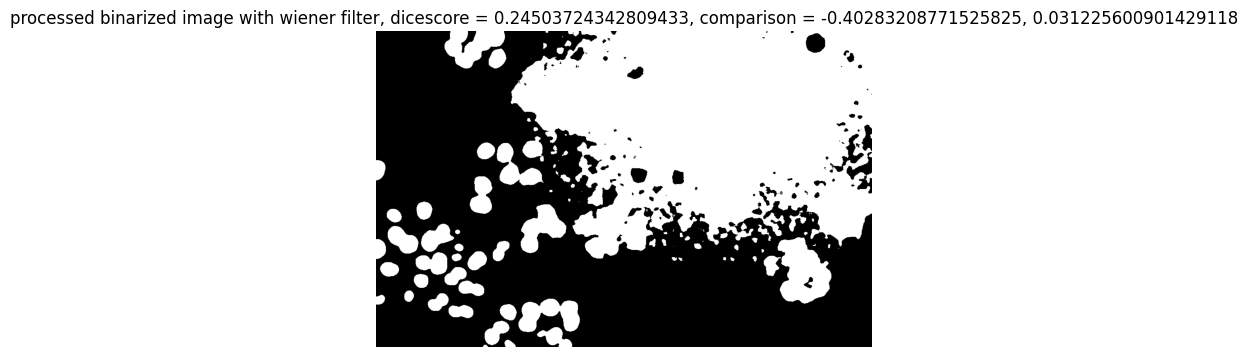

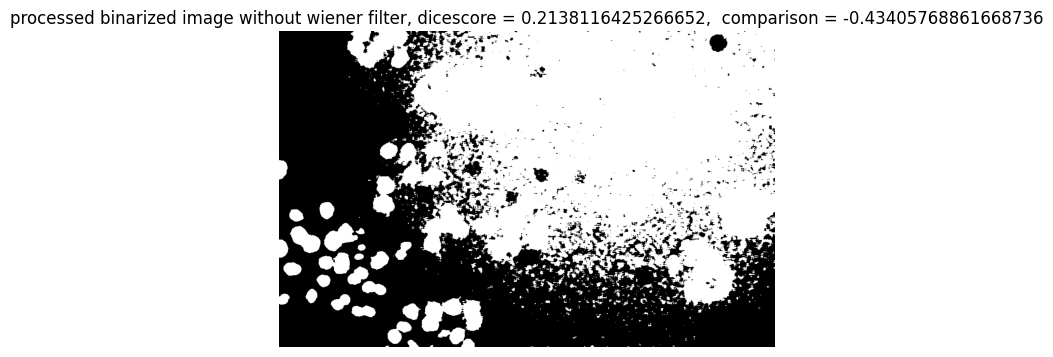

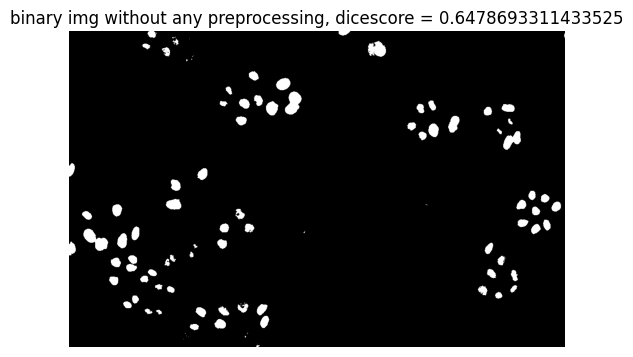

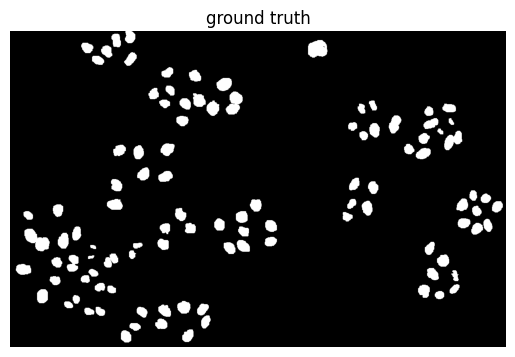

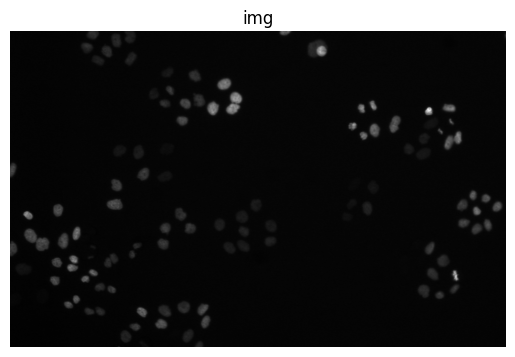

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
from skimage.filters import threshold_otsu

# reads image and scales to 0-1 
image = "data/N2DL-HeLa/img/t52.tif"
img = imread(image)

max = np.max(img)

img_scaled = (img/max)

groundtruth = "data/N2DL-HeLa/gt/man_seg52.tif"

gt = imread(groundtruth)

gt_boolean = gt == 0

gt = 1 - gt_boolean




def local_wiener_filter(image, window_size=5, noise_variance=None):
    """
    Apply a local adaptive Wiener filter to a grayscale image.

    Parameters:
    - image: 2D numpy array of the grayscale image.
    - window_size: size of the square window (odd integer).
    - noise_variance: estimated variance of the noise; if None, estimate globally.

    Returns:
    - filtered: the Wiener-filtered image as a 2D numpy array.
    """
    # Pad the image to handle borders
    pad = window_size // 2
    img_padded = np.pad(image, pad, mode='reflect')

    # Estimate global noise variance if not provided
    if noise_variance is None:
        noise_variance = np.var(image - np.mean(image))

    filtered = np.zeros_like(image)
    # Slide window over image
    for i in range(filtered.shape[0]):
        for j in range(filtered.shape[1]):
            window = img_padded[i:i+window_size, j:j+window_size]
            local_mean = window.mean()
            local_var = window.var()
            # Compute Wiener filter response
            if local_var > noise_variance:
                filtered[i, j] = local_mean + (local_var - noise_variance) / local_var * (image[i, j] - local_mean)
            else:
                filtered[i, j] = local_mean

    f = filtered
    f_norm = (f - f.min()) / (f.max() - f.min())
    filtered = f_norm
    return filtered



# Gamma transformation
def gammatransformation(image):
   """
    Every pixel value p is transformed by p^gamma.

    Parameters
    ----------
    parameter1 : gray level image
        A 2D array containing all the gray levels of each pixel.

    Returns 
    -------
    new image as 2D array.
       Each pixel value of the transformed image is result of p^gamma.
       Result is in the range 0-1
    """
   
   if np.max(image) != 1:
      image = image/np.max(image)  
  

   gamma = 10
 

   img_gamma = np.power(image, gamma)

   return img_gamma


# Histogram equalization
def histogramequalization(image):
   """
    Spreads the intensity values to the full range of 0-255.

    Parameters
    ----------
    parameter1 : gray level image
        A 2D array containing all the gray levels of each pixel.

    Returns 
    -------
    new image as 2D array.
       New image uses the full range of 0-255
    """
   if np.max(image) == 255:
      image_8bit = (image).astype(np.uint8)
   else:
      image_8bit = (image/np.max(image) * 255).astype(np.uint8)

   hist, bins = np.histogram(image_8bit.flatten(), bins=256, range=[0, 256])
  
   cdf = hist.cumsum()
  
   cdf_normalized = cdf * 255 / cdf[-1] 

   image_eq = cdf_normalized[image_8bit]

   image_eq = image_eq.astype(np.uint8)

   return image_eq

# Mean filter
def mean_filter(image, kernel_size = 3) -> np.ndarray:
    """
    Apply a mean filter (box blur) to a 2D grayscale image using only NumPy.

    Parameters
    ----------
    image : np.ndarray
        2D array of the grayscale image.
    kernel_size : int
        Size of the (square) kernel; must be odd.

    Returns
    -------
    filtered : np.ndarray
        The blurred image, same shape as input.
    """
    if kernel_size % 2 == 0:
        raise ValueError("kernel_size must be odd.")
    pad = kernel_size // 2
    # Spiegele die Ränder, damit wir auch am Rand filtern können
    img_padded = np.pad(image, pad, mode='reflect')
    H, W = image.shape
    filtered = np.empty_like(image, dtype=float)

    # Summen-Integralbild zur schnellen Fenster-Summen
    # Integralbild hat eine zusätzliche Null-Zeile/-Spalte vorne
    integral = np.cumsum(np.cumsum(img_padded, axis=0), axis=1)
    # Schleife über alle Pixel
    for i in range(H):
     for j in range(W):
      window = img_padded[i:i+kernel_size, j:j+kernel_size]
      filtered[i,j] = window.sum() / (kernel_size**2)
    return filtered

# Dice score
def dice_score(otsu_img, otsu_gt):

    # control if the Pictures have the same Size
    if len(otsu_img) != len(otsu_gt):
       if len(otsu_img) > len(otsu_gt):
         otsu_img = otsu_img[1:len(otsu_gt)]
       else:
        otsu_gt = otsu_gt[1:len(otsu_img)]


    # defining the variables for the Dice Score equation
    positive_overlap = 0
    sum_img = 0
    sum_gt = 0

    for t, p in zip(otsu_img, otsu_gt):
        if t == 1:
            sum_img += 1
        if p == 1:
            sum_gt += 1
        if t == 1 and p == 1:
            positive_overlap += 1

    if sum_img + sum_gt == 0:
        return 1.0

    return 2 * positive_overlap / (sum_img + sum_gt)


# Application of Wiener_filter, Gamma_transformation, Histogram_equalization, Otsu, Meanfilter, 2nd Otsu

# Wienerfilter
bg = local_wiener_filter(img_scaled, window_size=10)

img_filtered = img_scaled - bg

# Gamma
img_filtered_gamma = gammatransformation(img_filtered)

# Histogram equalization
img_filtered_gamma_eq = histogramequalization(img_filtered_gamma)


# Otsu thresholding of wiener image
T = threshold_otsu(img_filtered_gamma_eq)

binary_wiener = (img_filtered_gamma_eq > T).astype(np.uint8)

# Mean filter of wiener image
binary_meanfiltered_wiener = mean_filter(binary_wiener, kernel_size=7)


# 2nd Otsu thresholding of wiener image
T = threshold_otsu(binary_meanfiltered_wiener)

binary_wiener = (binary_meanfiltered_wiener > T).astype(np.uint8)

# Assign foreground to 1 and 0 to background of wiener image
binary_wiener = 1 - binary_wiener


# NOW WITHOUT WIENER FILTER

# Gamma transformation
img_gamma = gammatransformation(img)

# Histogram equalization without wiener filter
img_gamma_eq = histogramequalization(img_gamma)


# Otsu thresholding without wiener filter
T = threshold_otsu(img_gamma_eq)

binary = (img_gamma_eq > T).astype(np.uint8)

# Mean filter without wiener filter
binary_meanfiltered = mean_filter(binary, kernel_size=7)


# 2nd Otsu thresholding without wiener filter
T = threshold_otsu(binary_meanfiltered)

binary = (binary_meanfiltered > T).astype(np.uint8)





# Otsu thresholding on OG
T = threshold_otsu(img)
binary_img = (img > T).astype(np.uint8)


# Compute dice score
binary_wiener_flatten = binary_wiener.flatten()

binary_flatten = binary.flatten()

binary_img_flatten = binary_img.flatten()

gt_flattten = gt.flatten()

dice_score_binary_wiener = dice_score(binary_wiener_flatten, gt_flattten)

dice_score_binary = dice_score(binary_flatten, gt_flattten)

dice_score_binary_img = dice_score(binary_img_flatten, gt_flattten)

a = dice_score_binary - dice_score_binary_img
b = dice_score_binary_wiener - dice_score_binary_img
c = dice_score_binary_wiener - dice_score_binary

# Display image
plt.figure()
plt.imshow(binary_wiener, cmap='gray')
plt.title(f'processed binarized image with wiener filter, dicescore = {dice_score_binary_wiener}, comparison = {b}, {c}')
plt.axis('off')
plt.imshow

plt.figure()
plt.imshow(binary, cmap='gray')
plt.title(f'processed binarized image without wiener filter, dicescore = {dice_score_binary},  comparison = {a}')
plt.axis('off')
plt.imshow

plt.figure()
plt.imshow(binary_img, cmap='gray')
plt.title(f'binary img without any preprocessing, dicescore = {dice_score_binary_img}')
plt.axis('off')
plt.imshow


plt.figure()
plt.imshow(gt, cmap='gray')
plt.title("ground truth")
plt.axis('off')
plt.imshow

plt.figure()
plt.imshow(img, cmap='gray')
plt.title("img")
plt.axis('off')
plt.imshow

